In [103]:
# Import relevant libraries

import sys;

# setup path to location of gmlsnets_pytorch (if not install system-wide)
path_gmlsnets_pytorch = '../../';
sys.path.append(path_gmlsnets_pytorch);

import torch;
import torch.nn as nn;
import torch.nn.functional as F
import torch.optim as optim

import numpy as np;
import pickle;

import matplotlib.pyplot as plt;

import pdb
import time

import os

# setup gmlsnets package
import gmlsnets_pytorch as gmlsnets;
import gmlsnets_pytorch.nn;
import gmlsnets_pytorch.vis;
import gmlsnets_pytorch.dataset;

# dereference a few common items
MapToPoly_Function = gmlsnets.nn.MapToPoly_Function;
get_num_polys = MapToPoly_Function.get_num_polys;
weight_one_minus_r = MapToPoly_Function.weight_one_minus_r;
eval_poly = MapToPoly_Function.eval_poly;

print("Packages:");
print("torch.__version__ = " + str(torch.__version__));
print("numpy.__version__ = " + str(np.__version__));
print("gmlsnets.__version__ = " + str(gmlsnets.__version__));

Packages:
torch.__version__ = 1.5.0
numpy.__version__ = 1.18.1
gmlsnets.__version__ = 1.0.0


In [104]:
# Setup the parameters
batch_size = int(1e1);
flag_extend_periodic = False; # periodic boundaries
flag_dataset = 'diffOp2';
run_name = '%s_Test1'%flag_dataset;
base_dir = './output/regression_diff_op_2d/%s'%run_name;
flag_save_figs = True;
fig_base_dir = '%s/fig'%base_dir;
flag_print_model = False;

print("Settings:");
print("flag_dataset = " + flag_dataset);
print("run_name = " + run_name);
print("base_dir = " + base_dir);  

if not os.path.exists(base_dir):
  os.makedirs(base_dir);

if not os.path.exists(fig_base_dir):
  os.makedirs(fig_base_dir);

# Configure devices
if torch.cuda.is_available():  
  num_gpus = torch.cuda.device_count();
  print("num_gpus = " + str(num_gpus));
  if num_gpus >= 4:
    device = torch.device('cuda:3');
  else:
    device = torch.device('cuda:0');
else: 
  device = torch.device('cpu');
print("device = " + str(device));

Settings:
flag_dataset = diffOp2
run_name = diffOp2_Test1
base_dir = ./output/regression_diff_op_2d/diffOp2_Test1
device = cpu


In [105]:
Nx = 21;Ny = 21; 
nx = Nx; ny = Ny;

NNx = 3*Nx; NNy = 3*Ny; # simple periodic by tiling for now
aspect_ratio = NNx/float(NNy);
xx = np.linspace(-1.5,aspect_ratio*1.5,NNx); xx = xx.astype(float);
yy = np.linspace(-1.5,1.5,NNy); yy = yy.astype(float);

aa = np.meshgrid(xx,yy);
np_xj = np.array([aa[0].flatten(), aa[1].flatten()]).T;

aa = np.meshgrid(xx,yy);
np_xi = np.array([aa[0].flatten(), aa[1].flatten()]).T;

# make torch tensors
xj = torch.from_numpy(np_xj).float().to(device); # convert to torch tensors
xj.requires_grad = False;

xi = torch.from_numpy(np_xi).float().to(device); # convert to torch tensors
xi.requires_grad = False;

In [106]:
if flag_dataset == 'diffOp2':
  
  flag_verbose = 1;
  #op_type = r'\Delta{u}';op_type = r'\Delta{u}*\Delta{u}';
  #op_type = r'u\Delta{u}';op_type = r'\grad{u}';op_type = r'u\grad{u}';
  #op_type = r'\grad{u}\cdot\grad{u}';
  op_type = r'\grad{u}';
    
  num_dim = 2;
  num_training_samples = int(5e3);
  nchannels_u = 1;  
  Nc = nchannels_u;

  #alpha1 = 0.05;
  alpha1 = 0.3;
  scale_factor = 1e2;
  train_dataset = gmlsnets.dataset.diffOp2(op_type=op_type,op_params=None,
                                           gen_mode='exp1',gen_params={'alpha1':alpha1},
                                           num_samples=num_training_samples,
                                           nchannels=nchannels_u,nx=nx,ny=ny,
                                           noise_factor=0,scale_factor=scale_factor,
                                           flag_verbose=flag_verbose);
  
  train_dataset = train_dataset.to(device);
  if flag_verbose > 0:
    print("done.");

  num_test_samples = int(1e3);
  scale_factor = 1e2;
  test_dataset = gmlsnets.dataset.diffOp2(op_type=op_type,op_params=None,
                                          gen_mode='exp1',gen_params={'alpha1':alpha1},
                                          num_samples=num_test_samples,
                                          nchannels=nchannels_u,nx=nx,ny=ny,
                                          noise_factor=0,scale_factor=scale_factor,
                                          flag_verbose=flag_verbose);
  test_dataset = test_dataset.to(device);
    
  if flag_verbose > 0:
    print("done.");
  
else:
  msg = "flag_dataset not recognized.";
  msg += "flag_dataset = " + str(flag_dataset);
  raise Exception(msg);


# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True);
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=False);

# Cound number of output channels in f, determines if scalar or vector valued data
nchannels_f = train_dataset.samples_Y.shape[1];

Generating the data samples which can take some time.
num_samples = 5000
done.
Generating the data samples which can take some time.
num_samples = 1000
done.


saveFilename = ./output/regression_diff_op_2d/diffOp2_Test1/fig/samples_u.pdf
saveFilename = ./output/regression_diff_op_2d/diffOp2_Test1/fig/samples_u.png
saveFilename = ./output/regression_diff_op_2d/diffOp2_Test1/fig/samples_f.pdf
saveFilename = ./output/regression_diff_op_2d/diffOp2_Test1/fig/samples_f.png


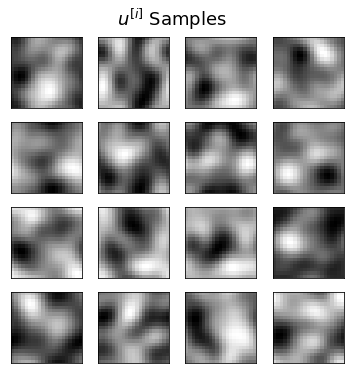

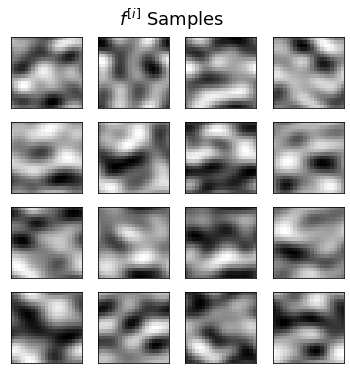

In [107]:
flag_run_cell = True;
if flag_run_cell:
    # Show subset of the data 
    img_arr = [];
    label_str_arr = [];

    numImages = len(train_dataset);
    #II = np.random.permutation(numImages); # compute random collection of indices @optimize
    II = np.arange(numImages);

    if flag_dataset == '' or 0 == 0:          
      img_arr = [];
      channelI = 0; # for vector-valued fields, choose component.
      for I in np.arange(0,min(num_training_samples,16)):        
        img_arr.append(train_dataset[II[I],channelI,:][0].cpu());
      gmlsnets.vis.plot_image_array(img_arr,title=r'$u^{[i]}$ Samples',figSize=(6,6),title_yp=0.95);
    
      if flag_save_figs:
        fig_name = 'samples_u';
        gmlsnets.vis.save_fig('%s/%s'%(fig_base_dir,fig_name),'',flag_verbose=True,dpi_set=200,flag_pdf=True);
        
      img_arr = [];
      channelI = 0;
      for I in np.arange(0,min(num_training_samples,16)):
        img_arr.append(train_dataset[II[I],channelI,:][1].cpu());      
      gmlsnets.vis.plot_image_array(img_arr,title=r'$f^{[i]}$ Samples',figSize=(6,6),title_yp=0.95);
    
      if flag_save_figs:
        fig_name = 'samples_f';
        gmlsnets.vis.save_fig('%s/%s'%(fig_base_dir,fig_name),'',flag_verbose=True,dpi_set=200,flag_pdf=True);

In [108]:
# Define heat map so we may plot our results
def heatmap2d(arr: np.ndarray):
    plt.imshow(arr, cmap='hot')
    plt.colorbar()
    plt.show()

In [109]:
# Create our CNN
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 1, 3, padding=(1,1))   # Convolution layer

    def forward(self, x):
        x = F.max_pool2d((self.conv1(x)), (1, 1))
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()
print(net)  # Print CNN details

Net(
  (conv1): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [110]:
# Our aim here is to learn Laplacian such that L[u] = g. Here, we find our data for u and g  and convert to tensors

amt_data = 5000  # Amount of data we'll use

for I in np.arange(0,min(num_training_samples,amt_data)):        
    img_arr.append(train_dataset[II[I],channelI,:][0].cpu());    # Extract initial function u
u_nontensor = img_arr   # Store input data, nontensors
u_data = torch.ones(1,1,21,21)   # Initialize new input data tensor
placeholder = torch.ones(1,1,21,21) # Placeholder that will store input data as a tensor

# Perform loops to convert input data to tensors
for k in np.arange(0,amt_data):
    for j in np.arange(0,21):
        for i in np.arange(0,21):
            placeholder[0,0,i,j] = u_nontensor[k][i,j]
    u_data = torch.cat((u_data, placeholder))  # Concatenate placeholder with filled-in values with our data tensor

# First entry is a placeholder tensor that we used to initialize tensor dimensions
# We can go ahead and remove it
u_data = u_data[1:amt_data]



        
for I in np.arange(0,min(num_training_samples,amt_data)):        
    img_arr.append(train_dataset[II[I],channelI,:][1].cpu());    # Extract output function g
g_nontensor = img_arr   # Store output data, nontensors
g_data = torch.ones(1,1,21,21)   # Initialize new output data tensor
placeholder2 = torch.ones(1,1,21,21)    # Placeholder that will store output data as a tensor

# Perform loops to convert output data to tensors
for k in np.arange(0,amt_data):
    for j in np.arange(0,21):
        for i in np.arange(0,21):
            placeholder2[0,0,i,j] = g_nontensor[k][i,j]    
    g_data = torch.cat((g_data, placeholder2))  # Concatenate placeholder with filled-in values with our data tensor

# First entry is a placeholder tensor that we used to initialize tensor dimensions
# We can go ahead and remove it
g_data = g_data[1:amt_data]

out = net(u_data)

print("Finished converting data to tensors. ")

Finished converting data to tensors. 


In [111]:
net.zero_grad()
out.backward(torch.ones(amt_data-1, 1, 21, 21))   

In [112]:
# Define custom loss function
def custom_loss_least_squares(val1,val2):  
  r"""Computes the Mean-Square-Error (MSE) over the entire batch."""
  diff_flat = (val1 - val2).flatten();
  N = diff_flat.shape[0];
  loss = torch.sum(torch.pow(diff_flat,2),-1)/N;
  return loss;

loss_func = custom_loss_least_squares

In [113]:
output = net(u_data)   # Output of CNN
target = g_data   # Target data that our CNN aims for
loss = loss_func(output, target)  # Find loss
print(loss)


tensor(0.4830, grad_fn=<DivBackward0>)


In [114]:
print(loss.grad_fn)  # MSELoss
print(loss.grad_fn.next_functions[0][0])  # Linear
print(loss.grad_fn.next_functions[0][0].next_functions[0][0])  # ReLU

In [115]:
net.zero_grad()     # zeroes the gradient buffers of all parameters

print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

loss.backward()

print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

conv1.bias.grad before backward
tensor([0.])
conv1.bias.grad after backward
tensor([0.4304])


In [116]:
learning_rate = 0.01
for f in net.parameters():
    f.data.sub_(f.grad.data * learning_rate)

In [117]:
num_iterations = 500   # Number of iterations of ur back prop
loss_vector = np.zeros(shape=(num_iterations,1))   # Vector to store loss values
index_vector = np.zeros(shape=(num_iterations,1))   # Stores iteration number for loss

for i in np.arange(1,num_iterations):
    index_vector[i-1] = i
    
    # Create optimizer
    optimizer = optim.Adam(net.parameters(), lr=0.01)
    
    # Perform back prop
    optimizer.zero_grad()   # Zero the gradient buffers
    output = net(u_data)
    loss = loss_func(output, target)
    loss.backward()
    loss_vector[i-1] = loss.detach()
    optimizer.step()    # Does the update

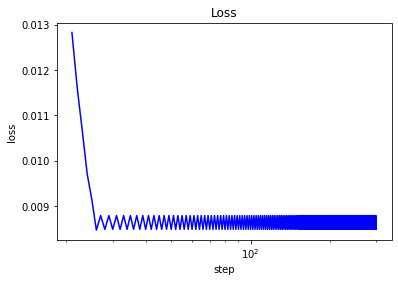

In [124]:
# Plot loss, semilogx plot
plt.semilogx(index_vector[20:300], loss_vector[20:300], "b-")
plt.xlabel('step');
plt.ylabel('loss');

plt.title('Loss');

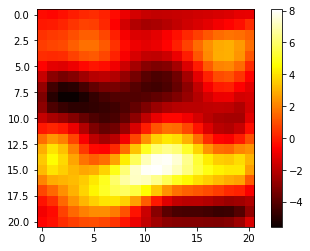

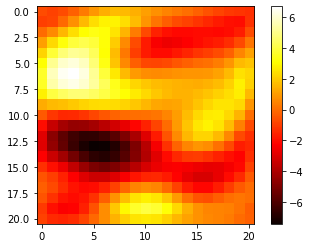

In [125]:
# Predicted solution: what the CNN produces
CNN_output = output.squeeze(0).detach().cpu().numpy()

# Extract particular plots
# The indices can be changed to graph different plots
CNN_output_ex1 = CNN_output[10][0,:,:]
CNN_output_ex2 = CNN_output[11][0,:,:]

heatmap2d(CNN_output_ex1)
heatmap2d(CNN_output_ex2)


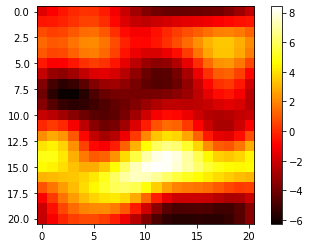

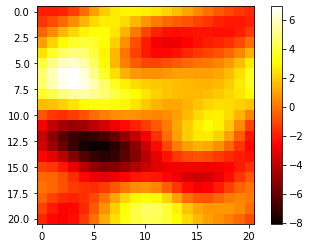

In [126]:
# Actual solution: the g in L[u] = g
g_output = g_data.squeeze(0).detach().cpu().numpy()

# Extract particular plots
# The indices can be changed to graph different plots
g_output_ex1 = g_output[10][0,:,:]
g_output_ex2 = g_output[11][0,:,:]

heatmap2d(g_output_ex1)
heatmap2d(g_output_ex2)

In [127]:
# Print convolution weights to see finite difference stencil
print(net.conv1.weight)

Parameter containing:
tensor([[[[ 0.0694, -0.0448,  0.3788],
          [ 0.0995,  0.2496, -0.0839],
          [ 0.1485,  0.2500,  0.0731]]]], requires_grad=True)
